In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import numpy as np
import pandas as pd
import os, sys
import scTRS.data_loader as dl
import pandas as pd
import numpy as np
from os.path import join
from statsmodels.stats.multitest import multipletests
import yaml
from scipy.stats import pearsonr

sys.path.append("/n/home12/khou/holystore/")
import paper_utils

import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_fdr_prop = pd.read_csv("data/summary_ct/drs_fdr_prop.tms_facs.csv", index_col=0)
df_drs_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)

df_ct_fdr = pd.DataFrame(
    multipletests(df_drs_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_drs_pval.shape
    ),
    index=df_drs_pval.index,
    columns=df_drs_pval.columns,
)

df_drs_pval = -np.log10(df_drs_pval)
df_ldsc_pval = pd.read_csv("data/summary_ct/ldsc_seg_pval.csv", index_col=0)
df_ldsc_pval = -np.log10(df_ldsc_pval)

In [3]:
list_numerical_pairs = [
    ("UKB_460K.bmd_HEEL_TSCOREz", "pancreatic_PP_cell"),
    ("PASS_Multiple_sclerosis", "granulocyte_monocyte_progenitor_cell"),
    ("PASS_MDD_Howard2019", "oligodendrocyte_precursor_cell"),
]

In [4]:
df_ldsc_fdr = pd.DataFrame(
    multipletests(
        np.power(10, -df_ldsc_pval.values.flatten()), alpha=0.05, method="fdr_bh"
    )[1].reshape(df_ldsc_pval.shape),
    index=df_ldsc_pval.index,
    columns=df_ldsc_pval.columns,
)

In [5]:
for pair in list_numerical_pairs:
    print(
        f"scDRS FDR prop: ({pair[0]}, {pair[1]}), {df_fdr_prop.loc[pair[0], pair[1]]}"
    )
    print(f"scDRS FDR: ({pair[0]}, {pair[1]}), {df_ct_fdr.loc[pair[0], pair[1]]}")
    print(f"LDSC-SEG FDR: ({pair[0]}, {pair[1]}), {df_ldsc_fdr.loc[pair[0], pair[1]]}")

scDRS FDR prop: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.323943661971831
scDRS FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.04612372030049677
LDSC-SEG FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.999999551316972
scDRS FDR prop: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.728
scDRS FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.020207582849949866
LDSC-SEG FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.2749842083794437
scDRS FDR prop: (PASS_MDD_Howard2019, oligodendrocyte_precursor_cell), 0.6217948717948718
scDRS FDR: (PASS_MDD_Howard2019, oligodendrocyte_precursor_cell), 0.020207582849949866
LDSC-SEG FDR: (PASS_MDD_Howard2019, oligodendrocyte_precursor_cell), 0.1019381775267783


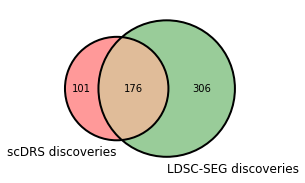

(47.24881899954701, 1.3974817302360676e-162)
[[8297.  101.]
 [ 306.  176.]]
Spearman's correlation: SpearmanrResult(correlation=0.2814526943873068, pvalue=2.370886100811751e-161)


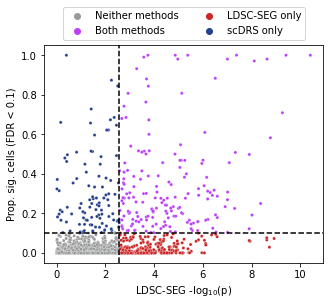

In [6]:
# import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

melted_df_ldsc_pval = df_ldsc_pval.reset_index().melt("index")
melted_df_ldsc_pval.columns = ["trait", "ct", "nlog10p"]
melted_df_trs_prop = df_fdr_prop.reset_index().melt("index")
melted_df_trs_prop.columns = ["trait", "ct", "fdr_prop"]

join_df = pd.merge(
    melted_df_ldsc_pval,
    melted_df_trs_prop,
    on=["trait", "ct"],
    suffixes=["_ldsc", "_trs"],
)

ldsc_signif_mask = multipletests(
    np.power(10, -join_df.nlog10p), alpha=0.05, method="fdr_bh"
)[0]

trs_signif_mask = join_df.fdr_prop > 0.1

from matplotlib_venn import venn2, venn2_circles
from scipy.stats import fisher_exact

plt.figure(figsize=(6, 3))
drs_signif_index = np.where(trs_signif_mask)[0]
ldsc_signif_index = np.where(ldsc_signif_mask)[0]

v = venn2(
    [set(drs_signif_index), set(ldsc_signif_index)],
    set_labels=(
        "scDRS discoveries",
        "LDSC-SEG discoveries",
    ),
)
c = venn2_circles([set(drs_signif_index), set(ldsc_signif_index)])
plt.savefig("results/ldsc_compare_drs_fdrprop_overlap.pdf", bbox_inches="tight")
plt.show()

contingency_tbl = np.zeros((2, 2))

contingency_tbl[1, 0] = len(set(ldsc_signif_index) - set(drs_signif_index))
contingency_tbl[0, 1] = len(set(drs_signif_index) - set(ldsc_signif_index))
contingency_tbl[1, 1] = len(set(drs_signif_index) & set(ldsc_signif_index))
contingency_tbl[0, 0] = (
    join_df.shape[0]
    - contingency_tbl[1, 0]
    - contingency_tbl[0, 1]
    - contingency_tbl[1, 1]
)

print(fisher_exact(contingency_tbl))
print(contingency_tbl)

print(f"Spearman's correlation: {spearmanr(join_df['nlog10p'], join_df['fdr_prop'])}")
join_df.loc[trs_signif_mask & ldsc_signif_mask, "label"] = "Both methods"
join_df.loc[trs_signif_mask & (~ldsc_signif_mask), "label"] = "scDRS only"
join_df.loc[(~trs_signif_mask) & ldsc_signif_mask, "label"] = "LDSC-SEG only"
join_df.loc[(~trs_signif_mask) & (~ldsc_signif_mask), "label"] = "Neither methods"


plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=join_df,
    x="nlog10p",
    y="fdr_prop",
    hue="label",
    s=10,
    palette={
        "LDSC-SEG only": "#cb2727",
        "scDRS only": "#26428b",
        "Both methods": "#be3ffb",
        "Neither methods": "#98999a",
    },
    alpha=1.0,
)
plt.xlabel("LDSC-SEG -log$_{10}$(p)")
plt.ylabel("Prop. sig. cells (FDR < 0.1)")
plt.axhline(y=0.1, color="black", ls="--")
plt.axvline(x=join_df.loc[ldsc_signif_index, "nlog10p"].min(), color="black", ls="--")
plt.legend(bbox_to_anchor=(0.05, 1.2), loc="upper left", ncol=2)
# plt.savefig("results/ldsc_compare_consistency.pdf", bbox_inches="tight")
plt.show()

In [7]:
melted_df_ldsc_pval = df_ldsc_pval.reset_index().melt("index")
melted_df_ldsc_pval.columns = ["trait", "ct", "ldsc_nlog10p"]
melted_df_drs_pval = df_drs_pval.reset_index().melt("index")
melted_df_drs_pval.columns = ["trait", "ct", "drs_nlog10p"]

join_df = pd.merge(
    melted_df_ldsc_pval,
    melted_df_drs_pval,
    on=["trait", "ct"],
    suffixes=["_ldsc", "_drs"],
)

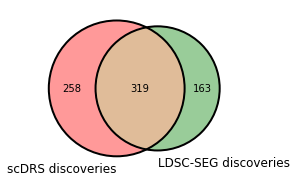

(61.745850573072715, 8.694601698948604e-295)
[[8140.  258.]
 [ 163.  319.]]
Pearson's correlation between LDSC-SEG and scDRS (0.6509529897070909, 0.0)


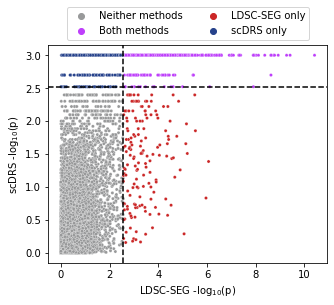

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

melted_df_ldsc_pval = df_ldsc_pval.reset_index().melt("index")
melted_df_ldsc_pval.columns = ["trait", "ct", "ldsc_nlog10p"]
melted_df_drs_pval = df_drs_pval.reset_index().melt("index")
melted_df_drs_pval.columns = ["trait", "ct", "drs_nlog10p"]

join_df = pd.merge(
    melted_df_ldsc_pval,
    melted_df_drs_pval,
    on=["trait", "ct"],
    suffixes=["_ldsc", "_drs"],
)

ldsc_signif_mask = multipletests(
    np.power(10, -join_df.ldsc_nlog10p), alpha=0.05, method="fdr_bh"
)[0]

drs_signif_mask = multipletests(
    np.power(10, -join_df.drs_nlog10p), alpha=0.05, method="fdr_bh"
)[0]

from matplotlib_venn import venn2, venn2_circles
from scipy.stats import fisher_exact

plt.figure(figsize=(6, 3))
drs_signif_index = np.where(drs_signif_mask)[0]
ldsc_signif_index = np.where(ldsc_signif_mask)[0]

v = venn2(
    [set(drs_signif_index), set(ldsc_signif_index)],
    set_labels=(
        "scDRS discoveries",
        "LDSC-SEG discoveries",
    ),
)
c = venn2_circles([set(drs_signif_index), set(ldsc_signif_index)])
plt.savefig("results/ldsc_compare_drs_pval_overlap.pdf", bbox_inches="tight")
plt.show()

contingency_tbl = np.zeros((2, 2))

contingency_tbl[1, 0] = len(set(ldsc_signif_index) - set(drs_signif_index))
contingency_tbl[0, 1] = len(set(drs_signif_index) - set(ldsc_signif_index))
contingency_tbl[1, 1] = len(set(drs_signif_index) & set(ldsc_signif_index))
contingency_tbl[0, 0] = (
    join_df.shape[0]
    - contingency_tbl[1, 0]
    - contingency_tbl[0, 1]
    - contingency_tbl[1, 1]
)

print(fisher_exact(contingency_tbl))
print(contingency_tbl)
join_df.loc[drs_signif_mask & ldsc_signif_mask, "label"] = "Both methods"
join_df.loc[drs_signif_mask & (~ldsc_signif_mask), "label"] = "scDRS only"
join_df.loc[(~drs_signif_mask) & ldsc_signif_mask, "label"] = "LDSC-SEG only"
join_df.loc[(~drs_signif_mask) & (~ldsc_signif_mask), "label"] = "Neither methods"


plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=join_df,
    x="ldsc_nlog10p",
    y="drs_nlog10p",
    hue="label",
    s=10,
    palette={
        "LDSC-SEG only": "#cb2727",
        "scDRS only": "#26428b",
        "Both methods": "#be3ffb",
        "Neither methods": "#98999a",
    },
    alpha=1.0,
)
plt.xlabel("LDSC-SEG -log$_{10}$(p)")
plt.ylabel("scDRS -log$_{10}$(p)")
plt.axvline(
    x=join_df.loc[ldsc_signif_index, "ldsc_nlog10p"].min(), color="black", ls="--"
)
plt.axhline(
    y=join_df.loc[drs_signif_index, "drs_nlog10p"].min(), color="black", ls="--"
)
plt.legend(bbox_to_anchor=(0.05, 1.2), loc="upper left", ncol=2)
print(
    f"Pearson's correlation between LDSC-SEG and scDRS",
    pearsonr(join_df.ldsc_nlog10p.values, join_df.drs_nlog10p.values),
)
plt.show()

In [9]:
melted_df_fdr_prop = df_fdr_prop.reset_index().melt("index")
melted_df_fdr_prop.columns = ["trait", "ct", "drs_fdr_prop"]
melted_df_drs_pval = df_drs_pval.reset_index().melt("index")
melted_df_drs_pval.columns = ["trait", "ct", "drs_nlog10p"]

join_df = pd.merge(
    melted_df_fdr_prop,
    melted_df_drs_pval,
    on=["trait", "ct"],
    suffixes=["_fdr_prop", "_pval"],
)
print(
    "Spearman correlation between FDR proportion and -log10(p)",
    spearmanr(join_df.drs_fdr_prop.values, join_df.drs_nlog10p),
)

Spearman correlation between FDR proportion and -log10(p) SpearmanrResult(correlation=0.4943098637198548, pvalue=0.0)
